# Data Ingestion and BERT Preparation

# A. Environment Setup

In [0]:
!pip install bert-for-tf2
!pip install sentencepiece

     |████████████████████████████████| 40kB 2.3MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.13.5-cp36-none-any.whl size=29948 sha256=38e981570ffdee394687e163c8ef3d723f2daf96598222d44e3e5f53ba30b49d
  Stored in directory: /root/.cache/pip/wheels/ed/11/48/86aff8a0442aa4728c921027a4100ac28878e9d977e76e2d52
  Created wheel for py-params: filename=py_params-0.9.2-cp36-none-any.whl size=6003 sha256=1314a7dfc645d6caf3085e0b9b3ca933bc271ee7bb4a43fafbc07dfc77376f45
  Stored in directory: /root/.cache/pip/wheels/da/d9/3a/d0b0aa570115d3a1a978deac820abc2afe34d7ca5e85dc236f
  Created wheel for params-flow: filename=params_flow-0.7.4-cp36-none-any.whl size=16195 sha256=fe4fdeac91ec050edf5344bcd08936d7c5b0b1c1a30489f470956342c9d2ae38
  Stored in directory: /root/.cache/pip/wheels/86/30/40/507b60d68b67ac87f35e95c98f5b296a32f146d5ae1d1d5aa7
Successfully built bert-for-tf2 py-params params-flow
     |████████████████████████████████| 1.0MB 3.4MB/s 


In [0]:
%tensorflow_version 2.x

In [0]:
import pandas as pd
import numpy as np
import nltk
import sklearn

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import io
import os
import math
import zipfile
import time

from tqdm import tqdm
from pprint import pprint

# Suppress new window for plots
%matplotlib inline 

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import bert

In [0]:
from tensorflow.keras.models import  Model
from tqdm import tqdm
from collections import namedtuple

In [0]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
print("TensorFlow Version:",tf.__version__)
print("Hub version: ",hub.__version__)
print('sklearn: %s' % sklearn.__version__)

TensorFlow Version: 2.2.0-rc2
Hub version:  0.7.0
sklearn: 0.22.2.post1


In [0]:
from google.colab import files, drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import gc
gc.collect() # Force garbage collector to release unreferenced memory
!ls

drive  sample_data


# B. Functions

## B.1 Global Variables

In [0]:
path_to_data = "/content/drive/My Drive/Colab Notebooks/W266 Final Project/data/"
zip_filename = "ticket_data_10_years_post_rtf.zip"
#csv_filename = "ticket_data_10_years_post_rtf.csv"
csv_filename = "ticket_data_dec_19_post_rtf.csv"

## B.2 Data Pre-Processing Functions

In [0]:
def text_company(df, text_field):  
  print("Starting text_company()...")
  start = time.time()
  df[text_field] = df[text_field].str.lower()
  end = time.time()
  print("Finished making it lowercase:", (end - start))
  
  start = time.time()  
  df[text_field] = df[text_field].str.replace(r"greenshades support", "clientswsupport")
  end = time.time()
  print("Finished removing 'greenshades support':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"greenshades software support", "clientswsupport")
  end = time.time()  
  print("Finished removing 'greenshades software support':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"greenshades partner support", "partnerswsupport")
  end = time.time()
  print("Finished removing 'greenshades partner support':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"greenshades ticket", "ticket")
  end = time.time()
  print("Finished removing 'greenshades ticket':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"greenshades online", "")
  end = time.time()
  print("Finished removing 'greenshades online':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"www.greenshades.com", "")
  end = time.time()
  print("Finished removing 'www.greenshades.com':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"greenshadesonline.com", "")
  end = time.time()
  print("Finished removing 'greenshadesonline.com':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"greenshades", "")
  end = time.time()
  print("Finished removing 'greenshades':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"green shades", "")
  end = time.time()
  print("Finished removing 'green shades':", (end - start))
  print("Finished text_company().")
  return df

In [0]:
def text_normalize(df, text_field):
  print("Starting text_normalize()...")
  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"<[^>]+>", "") # Delete any string between "<" and ">"
  end = time.time()
  print("Finished deleting strings between <>")
  print (end - start)

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"www.*?.com", "") 
  end = time.time()
  print("Finished deleting websites:", (end - start))

  start = time.time()
  df[text_field] = df[text_field].str.replace(r"http\S+", "")
  end = time.time()
  print("Finished deleting http\S+:", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"\d+", "") # Remove any strings of numbers
  end = time.time()
  print("Finished deleting numbers:", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"@\S+", "")
  end = time.time()
  print("Finished removing S+:", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9\.\=]", " ")
  end = time.time()
  print("Finished removing non-alpha numerics excluding punctuation (.=):", (end - start)) # old .,;:!

  print("Finished text_normalize().")
  return df

In [0]:
def tokens_to_string(input_list):
  return ' '.join(input_list)

## B.3 Plotting Functions

In [0]:
def plot_cm(y_true, y_pred, figsize=(10,8)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    fig, ax = plt.subplots(figsize=figsize)
    colormap = sns.diverging_palette(220, 20, sep=20, as_cmap=True) #plt.cm.coolwarm #coolwarm_r reverse
    sns.heatmap(cm, 
                cmap=colormap, 
                annot=annot, 
                annot_kws={"size": 12}, 
                fmt='',
                linewidths=1, 
                square=True, 
                ax=ax)
    ax.set_title('Confusion Matrix\n', fontsize=16, weight='bold');
    ax.set_xlabel('\n\nPredicted Label', fontsize=12);
    ax.set_ylabel('Actual Label\n\n', fontsize=12);

In [0]:
def plt_barchart(df, title):
  sns.set_style("white")

  df2 = df.groupby('PriorityID').agg({'PriorityID':['count']}).reset_index()
  df2.columns = ['PriorityID', 'count']
  df2['pct'] = df2['count']*100/(sum(df2['count']))

  x = df2['PriorityID']
  y = df2['pct']

  palette = ['red','orange', 'green', 'yellow']

  fig, ax = plt.subplots(figsize = (8,4))
  fig = sns.barplot(y, x, estimator = sum, ci = None, orient='h', palette=palette)

  for i, v in enumerate(y):
    ax.text(v+1, i+.05, str(round(v,3))+'%', color='black', fontweight='bold')

  ax.set(xlim=(0,100))
  plt.title(title + '\nTicket Priority as Percentage of Total', size=16, weight='bold')
  plt.ylabel('Ticket Priority')
  plt.xlabel('% Total');

In [0]:
def plot_history(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

## B.4 Utility Functions

In [0]:
priority_dict = {'Low': 0,'Normal':1,'High':2,'Critical': 3}
def map_priority(priority, priority_dict = {}):
  val = priority_dict[priority]
  return val

In [0]:
def tokenize_note(note):
  '''Simple wrapper for tokenizing a note to its ids.'''
  return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(note))

In [0]:
def truncate_tokenized_note(tokenized_note,length):
  '''Truncates a tokenized note to the specified number of tokens(length).'''
  if len(tokenized_note) > length:
    tokenized_note = tokenized_note[:length]
  return tokenized_note

In [0]:
def create_tokenized_field(df, text_field, new_token_field):
  print("Starting create_tokenized_field()...")
  printAfter = 500000
  print("Total lines in loop")
  print(len(df[text_field]))
  start = time.time()

  new_tokens = [[]]*len(df[text_field])

  token_time = 0
  filter_time = 0
  assign_to_token_time = 0  

  for i in range(0, len(df[text_field])):
    start_inner = time.time()
    tokens = word_tokenize(df[text_field][i])
    end_inner = time.time()
    token_time += (end_inner - start_inner)

    start_inner = time.time()    
    filtered_tokens = [w for w in tokens]
    end_inner = time.time()
    filter_time += (end_inner - start_inner)

    start_inner = time.time()        
    new_tokens[i] = filtered_tokens
    end_inner = time.time()
    assign_to_token_time += (end_inner - start_inner)

    if i % printAfter == 0 and i != 0:      
      print("Finished lines:", i)
      print("Token Time:", token_time)
      print("Filter Time:", filter_time)
      print("Assign To Token Time:", assign_to_token_time)      
      token_time = 0
      filter_time = 0
      assign_to_token_time = 0    
      
  df[new_token_field] = new_tokens
  end = time.time()
  print("Create tokenized field time:", (end - start))
  start = time.time()

  print("Finished create_tokenized_field().")
  return df

In [0]:
def releaseDF(df):
    '''
    Release dataframe from memory
    '''
    list_df = [df]
    del list_df
    return

## B.5 BERT Data Preparation Functions

In [0]:
def create_single_input(sentence, MAX_LEN):
  stokens = tokenizer.tokenize(sentence)
  stokens = stokens[:MAX_LEN]
  stokens = ["[CLS]"] + stokens + ["[SEP]"]
 
  ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
  masks = get_masks(stokens, MAX_SEQ_LEN)
  segments = get_segments(stokens, MAX_SEQ_LEN)

  return ids, masks, segments

In [0]:
def create_input_array(sentences):
  input_ids, input_masks, input_segments = [], [], []

  for sentence in tqdm(sentences,position=0, leave=True):
    ids, masks, segments = create_single_input(sentence, MAX_SEQ_LEN-2)
    input_ids.append(ids)
    input_masks.append(masks)
    input_segments.append(segments)

  return [np.asarray(input_ids, dtype=np.int32),
          np.asarray(input_masks, dtype=np.int32), 
          np.asarray(input_segments, dtype=np.int32)]

In [0]:
def get_masks(tokens, max_seq_length):
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

# C. Ingest and Pre-Process Dataset

## C.1 Import Raw Dataset

In [0]:
#unzip data, only run if unzipped data not present in your Google Drive
#with zipfile.ZipFile(path_to_data + zip_filename, 'r') as zip_ref:
#    zip_ref.extractall(path_to_data)

In [0]:
start = time.time()
ticket_data = pd.read_csv(path_to_data + csv_filename, dtype = {'Notes': str})
#ticket_data = pd.read_csv(csv_filename, dtype = {'Notes': str})
ticket_data.Notes = ticket_data.Notes.fillna(' ')
end = time.time()
print("Loaded File:", (end - start))

Loaded File: 2.358160972595215


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (48,49) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# count the number of empty notes
count_empty = 0
for i in range(0, len(ticket_data['Notes'])):
  note = ticket_data['Notes'][i].strip()
  if len(note) == 0:
    count_empty += 1
  
print("Number of Blank Notes", count_empty)
print("Blank Note %:", count_empty / len(ticket_data['Notes']))

Number of Blank Notes 4135
Blank Note %: 0.14590169718781976


## C.2 View Dataframe

In [0]:
ticket_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28341 entries, 0 to 28340
Data columns (total 71 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   BugActionID               28341 non-null  int64  
 1   BugID                     28341 non-null  int64  
 2   ActionUserID              28341 non-null  object 
 3   ActionTime                28341 non-null  object 
 4   AssignedID                28341 non-null  object 
 5   Notes                     28341 non-null  object 
 6   StatusID                  28341 non-null  object 
 7   PriorityID                28341 non-null  object 
 8   BAContactID               26734 non-null  float64
 9   UpdateType                26727 non-null  object 
 10  ResolutionID              24412 non-null  float64
 11  ClientTouched             22000 non-null  object 
 12  CodeChanged               20338 non-null  object 
 13  ClientEmailed             20338 non-null  object 
 14  Client

## C.3 Sequence by BugID

In [0]:
#First, ensure that the dataframe is in the correct order. This should probably first be moved up to the data pre-processing.
ticket_data = ticket_data.sort_values(['BugID','ActionOrder'])

#group the data on the BugID and aggregate all of the features into lists for each feature. List maintains insertion order
# following the sort on ActionOrder above.
ticket_data_sequenced = ticket_data.groupby('BugID').aggregate(lambda attr: attr.tolist())
#examine the sequenced data
ticket_data_sequenced.head()

,BugActionID,ActionUserID,ActionTime,AssignedID,Notes,StatusID,PriorityID,BAContactID,UpdateType,ResolutionID,ClientTouched,CodeChanged,ClientEmailed,ClientPhoned,UserDepartment,UserPosition,NextBugActionID,LastTouchPrevToCloseID,OpenAfterCloseID,NextCloseConfirmedID,RawHours,BusinessHours,LastCloseID,ActionOrder,RedirectStatus,Title,Directory,ProductID,ReportedID,Description,compid,contactid,Originated,KBArticleID,CurrentResolutionID,OpenedTime,LastBugActionID,WasLow,WasAssignedToDev,LastBugActionStatus,NumBugActions,LastContact,WasEscalatedPastRepLevel,WorkspaceID,Summary,ClientTemp,MajorityPriorityID,SupportFailbyDev,SupportFailConfirm,Classification,HighestPriorityID,owner,IsEFP,LastRedirectStatus,ChangeDateTime,HistorySummary,HistoryClientTemp,UserID,ClosestBugActionID,ArticleID,KBTitle,NumUses,NumTimesEscalated,DefaultPriorityID,PackageID,KBProductID,Active,UserFriendlyDesc,SalesProductGroupID,DefaultClassification
BugID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
505111,"[3486141, 3486142, 3486361, 3486397, 3486423]","[TaxServiceSupport, TaxServiceSupport, jbaughn...","[2019-12-01 09:56:38.470000000, 2019-12-01 09:...","[TaxServiceSupport, Tax Service Support, TFC/P...","[(Created), **EFP-Auto-Ticket-Action** Error ...","[Open, In Progress, In Progress, Fixed, Closed]","[Normal, Normal, Normal, Normal, Normal]","[41190.0, 41190.0, 41190.0, 41190.0, 41190.0]","[Opened, Working, Redirected, Fixed, Worked]","[nan, nan, 0.0, 0.0, 0.0]","[nan, nan, False, False, True]","[nan, nan, False, False, False]","[nan, nan, False, False, True]","[nan, nan, False, False, False]","[nan, nan, Payroll Tax Service, Development, P...","[nan, nan, Tax Service Support Manager, Develo...","[3486142.0, 3486361.0, 3486397.0, 3486423.0, nan]","[nan, nan, nan, nan, 3486397.0]","[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[0.0, 23.8833, 0.2, 0.2167, nan]","[0.0, 0.8167, 0.2, 0.2167, nan]","[nan, nan, nan, nan, 3486423.0]","[1, 2, 3, 4, 5]","[nan, nan, nan, nan, nan]","[EFP: Submission hung or stalling, EFP: Submis...","[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[TaxServiceSupport, TaxServiceSupport, TaxServ...","[Error in EFP, Error in EFP, Error in EFP, Err...","[3701, 3701, 3701, 3701, 3701]","[41190, 41190, 41190, 41190, 41190]","[nan, nan, nan, nan, nan]","[1545, 1545, 1545, 1545, 1545]","[0.0, 0.0, 0.0, 0.0, 0.0]","[2019-12-01 14:56:37.973000000, 2019-12-01 14:...","[3486423, 3486423, 3486423, 3486423, 3486423]","[False, False, False, False, False]","[True, True, True, True, True]","[Closed, Closed, Closed, Closed, Closed]","[5, 5, 5, 5, 5]","[2019-12-02 10:14:47.060000000, 2019-12-02 10:...","[True, True, True, True, True]","[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[Not Support Related, Not Support Related, Not...","[Normal, Normal, Normal, Normal, Normal]","[nan, nan, nan, nan, nan]","[True, True, True, True, True]","[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[1545, 1545, 1545, 1545, 1545]","[EFP: Submission hung or stalling, EFP: Submis...","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[High, High, High, High, High]","[-1, -1, -1, -1, -1]","[40, 40, 40, 40, 40]","[0, 0, 0, 0, 0]","[nan, nan, nan, nan, nan]","[30, 30, 30, 30, 30]","[nan, nan, nan, nan, nan]"
505112,"[3486143, 3486144, 3486312, 3486316]","[TaxServiceSupport, TaxServiceSupport, Support...","[2019-12-01 10:50:12.237000000, 2019-12-01 10:...","[TaxServiceSupport, TFC Development, Support, ...","[(Created), **EFP-Auto-Ticket-Action** Error ...","[Open, In Progress, Closed, Close Confirmed]","[Normal, Normal, Normal, Normal]","[140294.0, 140294.0, 140294.0, 140294.0]","[Opened, Working, Worked, Worked]","[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]

## C.4 Pre-Process Notes field

In [0]:
# set up the Priorities at ints
priority_dict = {'Low': 0,'Normal':1,'High':2,'Critical': 3}
if ("10_years" in csv_filename):
  nan = ticket_data.PriorityID.unique()[4]
  priority_dict = {'Low': 0,'Normal':1,'High':2,'Critical': 3, 'normal': 1, nan: 1}

ticket_data['PriorityID_Int'] = ticket_data.PriorityID.apply(map_priority, priority_dict = priority_dict)

In [0]:
print("Starting Text Cleaning...")
# Should take about 2-3 minutes

print("Copy Notes into new Column")
start = time.time()
ticket_data["clean_notes"] = ticket_data.Notes
end = time.time()
print(end - start)

print("Remove Company Name Text")
start = time.time()
ticket_data = text_company(ticket_data, "clean_notes")
end = time.time()
print(end - start)

print("Text Normalize")
start = time.time()
ticket_data = text_normalize(ticket_data, "clean_notes")
end = time.time()
print(end - start)

Starting Text Cleaning...
Copy Notes into new Column
0.0018186569213867188
Remove Company Name Text
Starting text_company()...
Finished making it lowercase: 0.04339599609375
Finished removing 'greenshades support': 0.04736161231994629
Finished removing 'greenshades software support': 0.041295766830444336
Finished removing 'greenshades partner support': 0.03930807113647461
Finished removing 'greenshades ticket': 0.03906869888305664
Finished removing 'greenshades online': 0.037989139556884766
Finished removing 'www.greenshades.com': 0.03866267204284668
Finished removing 'greenshadesonline.com': 0.04038381576538086
Finished removing 'greenshades': 0.046312570571899414
Finished removing 'green shades': 0.04017949104309082
Finished text_company().
0.41837048530578613
Text Normalize
Starting text_normalize()...
Finished deleting strings between <>
0.05147504806518555
Finished deleting websites: 0.043450117111206055
Finished deleting http\S+: 0.0407261848449707
Finished deleting numbers: 0.27

In [0]:
print("Create tokenized_notes field")
ticket_data = create_tokenized_field(ticket_data, "clean_notes", "tokenized_notes")

Create tokenized_notes field
Starting create_tokenized_field()...
Total lines in loop
28341
Create tokenized field time: 13.234101295471191
Finished create_tokenized_field().


In [0]:
ticket_data["EmptyNote"] = ticket_data.tokenized_notes.apply(lambda x: 1 if len(x)==0 else 0)

In [0]:
# Remove empty notes
ticket_data = ticket_data[ticket_data.EmptyNote==0]

In [0]:
ticket_data.PriorityID.unique()

array(['Normal', 'High', 'Low', 'Critical'], dtype=object)

In [0]:
ticket_data["label_pr_low"] = ticket_data.PriorityID.apply(lambda x: 1 if x=="Low" else 0)
ticket_data["label_pr_norm"] = ticket_data.PriorityID.apply(lambda x: 1 if x=="Normal" else 0)
ticket_data["label_pr_high"] = ticket_data.PriorityID.apply(lambda x: 1 if x=="High" else 0)
ticket_data["label_pr_crit"] = ticket_data.PriorityID.apply(lambda x: 1 if x=="Critical" else 0)

## C.5 Prepare Dataset for BERT Layer

In [0]:
ticket_data.columns

Index(['BugActionID', 'BugID', 'ActionUserID', 'ActionTime', 'AssignedID',
       'Notes', 'StatusID', 'PriorityID', 'BAContactID', 'UpdateType',
       'ResolutionID', 'ClientTouched', 'CodeChanged', 'ClientEmailed',
       'ClientPhoned', 'UserDepartment', 'UserPosition', 'NextBugActionID',
       'LastTouchPrevToCloseID', 'OpenAfterCloseID', 'NextCloseConfirmedID',
       'RawHours', 'BusinessHours', 'LastCloseID', 'ActionOrder',
       'RedirectStatus', 'Title', 'Directory', 'ProductID', 'ReportedID',
       'Description', 'compid', 'contactid', 'Originated', 'KBArticleID',
       'CurrentResolutionID', 'OpenedTime', 'LastBugActionID', 'WasLow',
       'WasAssignedToDev', 'LastBugActionStatus', 'NumBugActions',
       'LastContact', 'WasEscalatedPastRepLevel', 'WorkspaceID', 'Summary',
       'ClientTemp', 'MajorityPriorityID', 'SupportFailbyDev',
       'SupportFailConfirm', 'Classification', 'HighestPriorityID', 'owner',
       'IsEFP', 'LastRedirectStatus', 'ChangeDateTime', 'Hi

In [0]:
dataset = ticket_data[['PriorityID', 'PriorityID_Int', 'clean_notes',
                       'label_pr_low','label_pr_norm', 
                       'label_pr_high', 'label_pr_crit']]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24199 entries, 0 to 28340
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   PriorityID      24199 non-null  object
 1   PriorityID_Int  24199 non-null  int64 
 2   clean_notes     24199 non-null  object
 3   label_pr_low    24199 non-null  int64 
 4   label_pr_norm   24199 non-null  int64 
 5   label_pr_high   24199 non-null  int64 
 6   label_pr_crit   24199 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.5+ MB


In [0]:
dataset = dataset.rename(columns={"PriorityID_Int": "label", 
                                  "clean_notes": "text"})
dataset.head(5)

,PriorityID,label,text,label_pr_low,label_pr_norm,label_pr_high,label_pr_crit
0,Normal,1,created,0,1,0,0
1,Normal,1,efp auto ticket action error while handli...,0,1,0,0
2,Normal,1,this seems to be stuck on submitting,0,1,0,0
3,Normal,1,submitted,0,1,0,0
4,Normal,1,closing,0,1,0,0


In [0]:
dataset.reset_index(inplace=True, drop=True)
dataset = dataset.copy(deep=True)
#releaseDF(ticket_data)

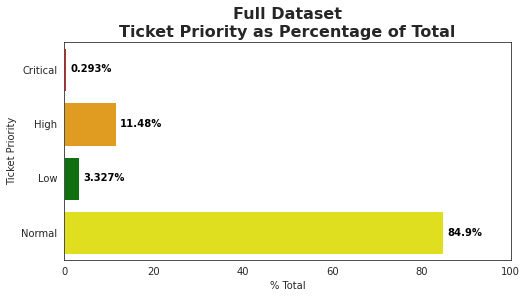

In [0]:
plt_barchart(dataset, "Full Dataset")

## C.6 Save Pre-Processed Dataset

In [0]:
# Save dataframe to shared Google drive project data folder
filename = "dataset.csv"
dataset.to_csv(path_to_data + filename)
#dataset.to_csv(filename)